<a href="https://cognitiveclass.ai"><img src = "https://imagenes.20minutos.es/files/article_amp/uploads/imagenes/2021/01/28/corruption-2727571-1280-1.png" width = 400> </a>

<h1 align=center><font size = 6>Fake news detection through Machine Learning</font></h1>

## Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#1)<br>
2. [Data adquisition and cleaning](#2)<br>
    1. [Data Cleaning](#21)
    2. [Data Wrangling / Preprocessing](#22)
    3. [Feature Selection](#23)
    4. [Final Dataframe](#24)
3. [Exploratory data Analysis (EDA)](#3) <br>
    1. [Descriptive Statistical Analysis](#31)
    2. [Correlation and Causation](#32)
    3. [Word Cloud](#33)
4. [Text Representation](#4) <br>
    1. [TF-IDF](#41)
    2. [Documet Embedding](#42)
6. [Model Development](#5) <br>
    1. [Logistic Regresssion](#51)
    2. [Neural Networks](#52)
7. [Results](#7) <br>
8. [Conclusion](#8) <br> 
</div>
<hr>

## Introduction <a id="1"></a>
### NOTA: El objetivo de este notebook es la ejecución con un conjunto de datos de prueba.

Como se menciona en el titulo, vamos a diseñar un modelo de predicción orientado a la detección de noticias falsas. Para esta tarea emplearemos dos formas diferentes de representar palabras y utilizaremos dos modelos logísticos diferentes. A diferencia de proyectos anteriores, vamos a trabajar con dos features que son de tipo texto, añadiendo asi algo de complejidad extra al proyecto.

Nuestro objetivo será comparar resultados entre representaciones diferentes y obtener un clasificador que realice de forma correcta la clasificación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import metrics
from gensim import models
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
from sklearn import preprocessing
import pickle
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from wordcloud import WordCloud
from spellchecker import SpellChecker

In [2]:
# == #

<hr>

## 2. Data adquisition and cleaning<a id="2"></a>

Primero de todo, obtendremos el conjunto de datos.

In [3]:
df_fake = pd.read_csv("./Data/dummy_fake.csv")
df_real = pd.read_csv("./Data/dummy_real.csv")

Como se observa, los datos estan divididos en dos conjuntos de datos dependiendo de la clase, es por ello que vamos a unirlos para poder trabajar con mas comodidad.

In [4]:
df_fake["label"] = "fake"
df_real["label"] = "real"
df_news = pd.concat([df_fake,df_real]).sample(frac=1)
df_news.reset_index(drop=True, inplace=True)

### 2.1 Data Cleaning<a id="21"></a>
Es importante mantener solo los features que más nos interesan, es por ello que vamos a eliminar todo lo que no este relacionado con el texto. Ya que la naturaleza de esta tarea es la clasificación mediante el texto. Del mismo modo, tenemos que eliminar los atributos que tengan muchos valores nulos.

<AxesSubplot:>

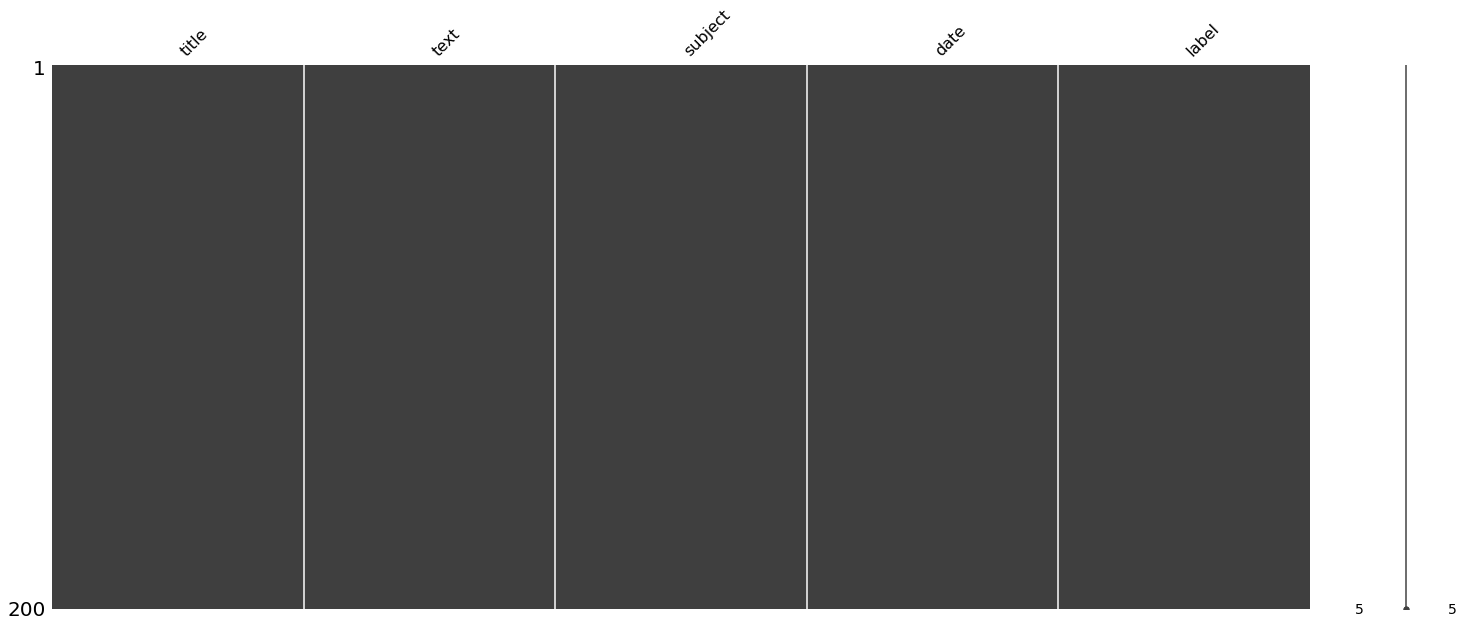

In [5]:
msno.matrix(df_news)

Como podemos observar, no encontramos valores nulos, es por ello que no es necesario eliminar columnas por falta de valores.

###  2.2 Data Wrangling / Preprocessing<a id="22"></a>
El data Wrangling es el proceso de transformar y mappear los datos a un formato estandar. En nuestro caso, al estar trabajando con texto, intentaremos normalizar los datos intentando perder la menor cantidad de información.
Para ello es posible que generemos nuevas columnas a partir de la información extraida en el texto. Esta parte corresponde una parte importante del trabajo.,

In [6]:
df_news

,title,text,subject,date,label
0,Fox News Bans Gene Simmons For Life For Haras...,"Gene Simmons, the 68-year-old Kiss bassist and...",News,"November 22, 2017",fake
1,That Story Trump Just Told The Press About Ob...,"On Tuesday, Donald Trump told a story about Ai...",News,"November 14, 2017",fake
2,Trump's Supreme Court appointee Gorsuch plots ...,WASHINGTON (Reuters) - Eight months into his l...,politicsNews,"December 20, 2017",real
3,BREAKING: Michael Flynn CRACKS – Will Testify...,"Michael Flynn, Trump s embattled former nation...",News,"December 1, 2017",fake
4,WATCH: Fox Host Calls For A ‘Cleansing’ Of Th...,Judge Jeanine Pirro has continued her scream...,News,"December 10, 2017",fake
...,...,...,...,...,...
195,Trump Supporters Object To Prince Harry’s Rec...,Great Britain s Buckingham Palace announced ye...,News,"November 28, 2017",fake
196,Texas Governor Just Broke With Trump; This Is...,"Republicans in Texas, including Gov. Greg Abbo...",News,"November 19, 2017",fake
197,Trump aides hope win on taxes will stem slide ...,WASHINGTON (Reuters) - Near the end of Preside...,politicsNews,"December 20, 2017",real
198,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [7]:
df_fake["text"][3]

'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [8]:
df_real["text"][3]

'WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based inte

Despues de visualizar varias instancias de diferente clase, se han observado diferencias:
1. **Longitud:** Las noticias reales tienden a ser más largas.
2. **Menciones:** Las noticias falsas tienden a tener @ de twitter, lo cual hace que no sea una fuente muy fiable.
3. **URL:** Las noticias falsas tienden a tener mas URL que las verdaderas.

### 1. Longitud en base a la clase

In [9]:
def count_word_number(phrase):
    return len(phrase.split())

In [10]:
# Añadir una columna con la longitud de la frase.
df_fake['len'] = df_fake.apply(lambda row : count_word_number(row['text']), axis = 1)
df_real['len'] = df_real.apply(lambda row : count_word_number(row['text']), axis = 1)

<BarContainer object of 2 artists>

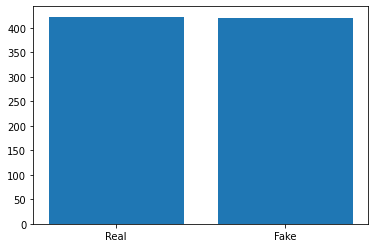

In [11]:
plt.bar(["Real","Fake"], [df_fake['len'].mean(),df_real['len'].mean()])

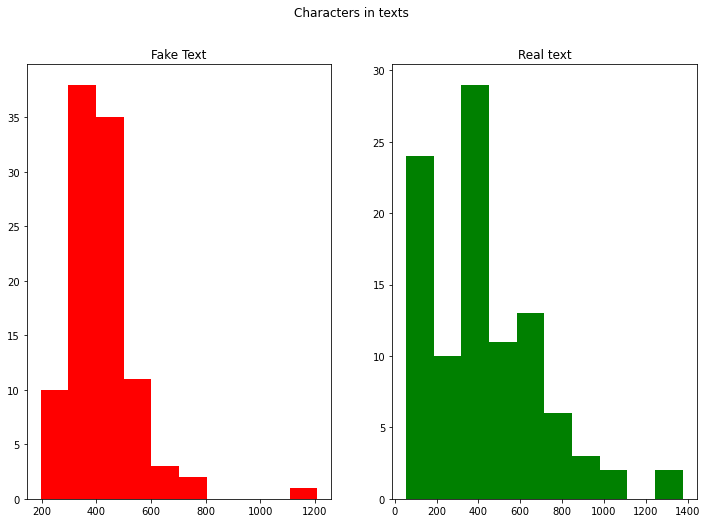

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df_fake['len'],color='red')
ax1.set_title('Fake Text')
ax2.hist(df_real["len"],color='green')
ax2.set_title('Real text')
fig.suptitle('Characters in texts')
plt.show()

### 2. Menciones

Como hemos mencionado anteriormente, es muy común utilizar menciones en redes sociales, es por ello que las noticias extraidas directamente de estas tienden a ser falsas.

In [13]:
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

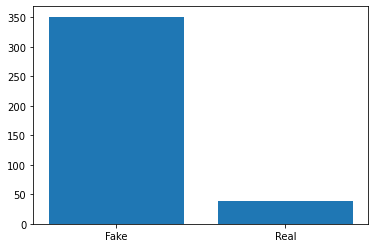

In [14]:
plt.bar(["Fake","Real"],[count_twitters_user(df_fake),count_twitters_user(df_real)])

Como se puede observar, existe una clara correlación entre la clase y la cantidad de menciones que se realizan en una noticia. Para analizar la corelación, vamos a usar Analysis of Variance (ANOVA)

### 3. URL

In [15]:
def count_url(df):
    url_re = re.compile(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(url_re, text))
    return count

def count_mention_text(text):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

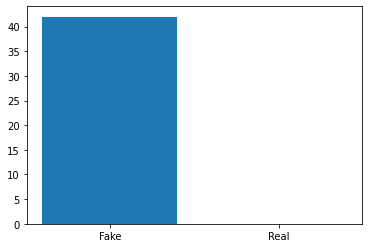

In [16]:
plt.bar(["Fake","Real"],[count_url(df_fake),count_url(df_real)])

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Pasar todo a minúsculas
3. Quitar los stopwords
4. Quitar las marcas de puntuacion
5. Corregir palabras
6. Lemmanization
7. Corregir palabras

### 1.Borrar las URL
En las noticias podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas. Del mismo modo, sabemos que las URL son indicadores de la veracidad de la noticia, es por ello que este valor vamos a guardarlo en una columna aparte.

In [17]:
df_preprocessed = pd.read_csv("./Data/dummy_news.csv")

In [18]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [19]:
df_preprocessed

,title,text,subject,date,label
0,Factbox: Big-ticket items at center of Congres...,(Reuters) - The U.S. Congress on Thursday appr...,politicsNews,"December 21, 2017",real
1,FBI deputy director to sit for closed intervie...,WASHINGTON (Reuters) - The FBI’S deputy direct...,politicsNews,"December 20, 2017",real
2,What's in the final Republican tax bill,(Reuters) - The U.S. House of Representatives ...,politicsNews,"December 19, 2017",real
3,"Trump signs tax, government spending bills int...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"December 22, 2017",real
4,House panel asks Trump ex-top aide Bannon to t...,"WASHINGTON (Reuters) - Steve Bannon, a former ...",politicsNews,"December 22, 2017",real
...,...,...,...,...,...
195,WATCH: Retired Alabama Cop: We Were Told To K...,It seems that Republican candidate for Attorne...,News,"November 22, 2017",fake
196,Don Jr. Tries To Mock Al Franken’s Resignatio...,When Sen. Al Franken (D-MN) announced his plan...,News,"December 7, 2017",fake
197,Trump nominates Liberty University professor t...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"December 19, 2017",real
198,WATCH: Lindsey Graham Trashes Media For Portr...,The media has been talking all day about Trump...,News,"December 20, 2017",fake


In [20]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_urls(text))

In [21]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_urls(text))

### 2. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [22]:
df_preprocessed["title"] = df_preprocessed["title"].str.lower()

In [23]:
df_preprocessed["text"] = df_preprocessed["text"].str.lower()

### 3. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [24]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

In [25]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_stopwords(text))

In [26]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_stopwords(text))

### 4. Quitar las marcas de puntuacion

Las marcas de puntuación no son relevantes, por tanto vamos a eliminarlo.

In [27]:
import string
def remove_punctuation(text:str):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(str.maketrans(PUNCT_TO_REMOVE, spaces))


In [28]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_punctuation(text))

In [29]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_punctuation(text))

### 5. Corregir palabras

In [30]:
df_preprocessed['title'] = df_preprocessed['title'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [31]:
df_preprocessed['text'] = df_preprocessed['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

df_preprocessed.to_csv("./Data/dummy_preprocess.csv",index=False)

In [32]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

### 6. Lemmanization
En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [33]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [35]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kerman/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [36]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: lemmatize_words(text))

In [37]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: lemmatize_words(text))

### 7. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [38]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

### 2.3 Feature Selection<a id="23"></a>
En este apartado vamos a seleccionar los atributos que nos interesan para nuestro conjunto de datos.


In [39]:
df_news.drop(["subject","date"],axis=1,inplace=True)

Primero eliminaremos estas dos columnas originales del conjunto de datos, ya que no nos interesan para la tarea a realizar.

Por otro lado, hemos observado de forma superficial la correlación entre la clase y la cantidad de menciones, es por ello que vamos añadirlo al conjunto de datos. Este atributo es valido debido a que está extraido directamente del texto.

In [40]:
df_preprocessed['has_mentions'] = df_preprocessed.apply(lambda row : count_mention_text(row['text'])>1, axis = 1)

### 2.4 Final Dataframe <a id="24"></a>

In [41]:
df_preprocessed.to_csv("./Data/dummy_preprocessed.csv")

<hr>

## Exploratory data Analysis (EDA) <a id="3">
    
En este apartado analizaremos los datos y sacaramos información que nos será de relevancia. Para ello usaremos el conjunto de datos que no hemos preprocesado.

In [42]:
df = pd.read_csv("./Data/dummy_preprocessed.csv")

In [43]:
df.loc[(df.label == 'real'),'label']=1  
df.loc[(df.label == 'fake'),'label']=0
df.loc[(df.has_mentions == 'True'),'has_mentions']=1  
df.loc[(df.has_mentions == 'False'),'has_mentions']=0

De este modo damos un valor numerico a la clase a predecir, lo cambiaremos mas adelante, pero por ahora lo tendremos como numerico para las métricas.

### Descriptive Statistical Analysis<a id="31">

### Correlation and Causation<a id="32">

In [44]:
df

,Unnamed: 0,title,text,subject,date,label,has_mentions
0,0,factbox big ticket item center congress spendi...,reuters u s congress thursday approved tempora...,politicsNews,"December 21, 2017",1,False
1,1,fbi deputy director sit closed interview house...,washington reuters fbi s deputy director andre...,politicsNews,"December 20, 2017",1,False
2,2,what s final republican tax bill,reuters u s house representative gave final ap...,politicsNews,"December 19, 2017",1,False
3,3,trump sign tax government spending bill law,washington reuters u s president donald trump ...,politicsNews,"December 22, 2017",1,False
4,4,house panel asks trump ex top aide bannon test...,washington reuters steve bannon former top whi...,politicsNews,"December 22, 2017",1,False
...,...,...,...,...,...,...,...
195,195,watch retired alabama cop told keep roy moore ...,seems republican candidate attorney general je...,News,"November 22, 2017",0,False
196,196,jr try mock al franken s resignation backfire ...,sen al franken d mn announced plan resign thur...,News,"December 7, 2017",0,False
197,197,trump nominates liberty university professor j...,washington reuters u s president donald trump ...,politicsNews,"December 19, 2017",1,False
198,198,watch lindsey graham trash medium portraying t...,medium talking day trump republican party scam...,News,"December 20, 2017",0,False


In [45]:
df['label']=np.float64(df['label'])
df['has_mentions']=np.float64(df['has_mentions'])
df['has_mentions'].corr(df['label'])

nan

De este modo comprobamos que nuestra suposición no era la mas correcta, ya que no hay una clara correspondencia entre estos dos atributos.

### Word Cloud<a id="33">

(-0.5, 1799.5, 1399.5, -0.5)

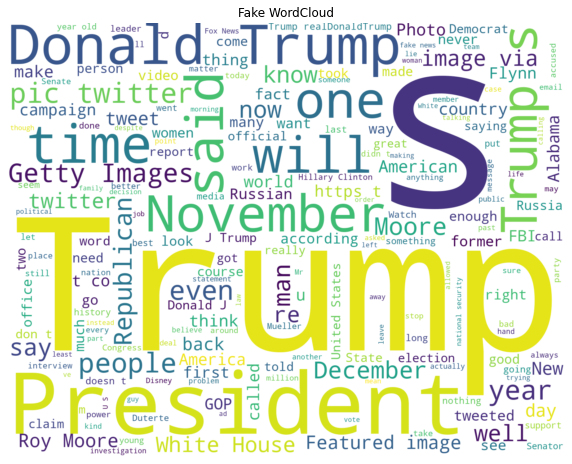

In [46]:
wc_fake = WordCloud(background_color='white',width=1800,height=1400).generate(' '.join(df_fake['text']))
plt.figure(figsize=(10,8))
plt.imshow(wc_fake, interpolation='bilinear')
plt.title("Fake WordCloud")
plt.axis("off")

(-0.5, 1799.5, 1399.5, -0.5)

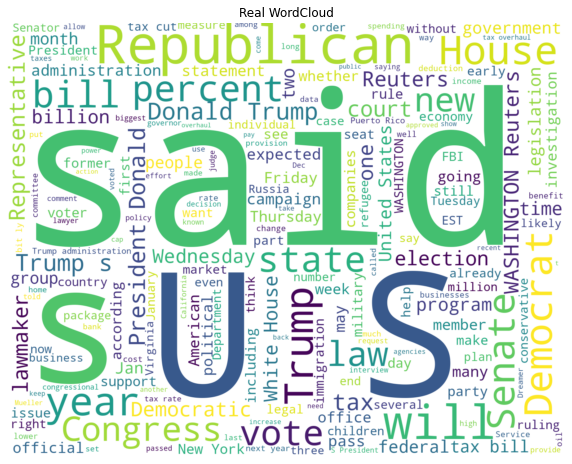

In [47]:
wc_real = WordCloud(background_color='white',width=1800,height=1400).generate(' '.join(df_real['text']))
plt.figure(figsize=(10,8))
plt.imshow(wc_real, interpolation='bilinear')
plt.title("Real WordCloud")
plt.axis("off")

<hr>

# Text Representation <a id="4">

Primero de todo, prepararemos el conjunto de datos para poder realizar la vectorización de forma adecuada, preprocesando y limpiando el texto.

## TF-IDF <a id="41">

In [48]:
df = pd.read_csv("./Data/dummy_preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [49]:
df.drop("title",axis=1,inplace=True)

In [50]:
text_data = np.array(df["text"])
print(len(text_data))
vectorizer = TfidfVectorizer(min_df = 15,stop_words='english') 
train_bow = vectorizer.fit_transform(text_data)
print("Tamaño de los datos depues de aplicar TF-IDF : ",train_bow.shape) #Modu honetan badakigu zenbat atributu ditugu.

200
Tamaño de los datos depues de aplicar TF-IDF :  (200, 391)


In [51]:
df_tf = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())
df_tf["label"] = df["label"] 
df.dropna(inplace=True) 

In [52]:
df_tf.to_csv("./Data/dummy_df_tf.csv",index=False)

## Document Embedding <a id="42">

In [53]:
df = pd.read_csv("./Data/dummy_preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [54]:
df.drop("title",axis=1,inplace=True)

In [55]:
df.shape

(200, 6)

In [56]:
lista = [str(i) for i in df['text'].copy().array]
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(lista)]
model = Doc2Vec(documents=tagged_data, min_count=30,vector_size = 50,workers = 5)

In [57]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("dummy_doc_2vec_model")
model.save(fname)
model.save("dummy_doc_2vec_model")
model = Doc2Vec.load("dummy_doc_2vec_model")  # you can continue training with the loaded model!

In [58]:
df_test = pd.DataFrame(columns=list(range(50)),index=list(range(200)))
tagged_df = pd.Series( (v[0] for v in tagged_data))
cosas = tagged_df.apply(model.infer_vector)
for i in range(df.shape[0]):
    df_test.loc[i] = pd.Series(cosas[i])

In [59]:
df_test.to_csv("./Data/dummy_df_50d.csv",index=False)
df_emb = pd.read_csv("./Data/dummy_df_50d.csv")

In [60]:
df = pd.read_csv("./Data/dummy_preprocessed.csv")
df_emb["has_mentions"] = df["has_mentions"]
df_emb["label"] = df["label"]
df_emb.to_csv("./Data/dummy_df_50d.csv",index=False)

<hr>

# Model Development <a id="5">

## Logistic Regresssion <a id="51">

### Logistic Regression with TF-IDF

In [61]:
df_tf = pd.read_csv("./Data/dummy_df_tf.csv")
df_tf.dropna(inplace=True) 

In [62]:
X = df_tf.drop(["label"],axis=1,inplace=False)
label_encoder = preprocessing.LabelEncoder().fit(df_tf['label'])
y = label_encoder.transform(df_emb['label'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [64]:
X_train

,according,account,accused,act,action,actually,added,administration,adviser,agency,...,win,woman,word,work,working,world,wrote,year,york,young
42,0.000000,0.000000,0.000000,0.0,0.000000,0.139101,0.000000,0.053624,0.0,0.000000,...,0.0,0.000000,0.000000,0.054660,0.063868,0.000000,0.0,0.032816,0.0,0.0
189,0.000000,0.058047,0.000000,0.0,0.000000,0.000000,0.060608,0.000000,0.0,0.000000,...,0.0,0.000000,0.053178,0.048371,0.000000,0.000000,0.0,0.261360,0.0,0.0
90,0.049917,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
136,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.057944,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.061816,0.0,0.0
51,0.115664,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.064031,0.000000,0.060220,0.000000,0.000000,0.0,0.036154,0.0,0.0
14,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.107723,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.085973,0.000000,0.000000,0.0,0.154844,0.0,0.0
92,0.000000,0.000000,0.000000,0.0,0.087658,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.093165,0.000000,0.0,0.000000,0.0,0.0
179,0.000000,0.111804,0.000000,0.0,0.000000,0.000000,0.000000,0.091402,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.108861,0.000000,0.0,0.111868,0.0,0.0


#### Vamos a obtener la mejor cantidad de atributos.

In [65]:
score = []
max_score = 0
values = []
aux = 0

for i in range(5,30,1):
    best_features = SelectKBest(k=i)
    fit = best_features.fit(X_train,np.ravel(y_train))
    df_new = df_tf[X.columns[fit.get_support()]]
    LR = LogisticRegression(max_iter=500,solver="saga")
    cv = KFold(n_splits=5)
    yhat = cross_val_predict(LR, df_new, y,cv=cv)
    score2 = metrics.f1_score(y, yhat,average='weighted')
    if (score2>max_score):
        max_score=score2
        aux = i
        bestFeatures = df_new
    score.append(score2)
    values.append(i)
    Valor = 'i: ' + str(i) + ' -> value: ' + str(score2) 
    print(Valor)

i: 5 -> value: 0.9699729756781104
i: 6 -> value: 0.9199919991999201
i: 7 -> value: 0.8946814112690891
i: 8 -> value: 0.8946814112690891
i: 9 -> value: 0.899507587177168
i: 10 -> value: 0.9197109594540345
i: 11 -> value: 0.9197109594540345
i: 12 -> value: 0.924772436620778
i: 13 -> value: 0.9147420948368815
i: 14 -> value: 0.9146393512590697
i: 15 -> value: 0.8944060339409177
i: 16 -> value: 0.9045969219954307
i: 17 -> value: 0.9096748293857888
i: 18 -> value: 0.9197994987468673
i: 19 -> value: 0.9146393512590697
i: 20 -> value: 0.9197994987468673
i: 21 -> value: 0.9097744360902256
i: 22 -> value: 0.9197994987468673
i: 23 -> value: 0.9147420948368815
i: 24 -> value: 0.9197994987468673
i: 25 -> value: 0.9097744360902256
i: 26 -> value: 0.9097744360902256
i: 27 -> value: 0.9097744360902256
i: 28 -> value: 0.924772436620778
i: 29 -> value: 0.924772436620778


In [66]:
m_score = 'MAX i: ' + str(aux) + ' -> MAX value: ' + str(max_score) 
print(m_score)

MAX i: 5 -> MAX value: 0.9699729756781104


Text(0, 0.5, 'Score')

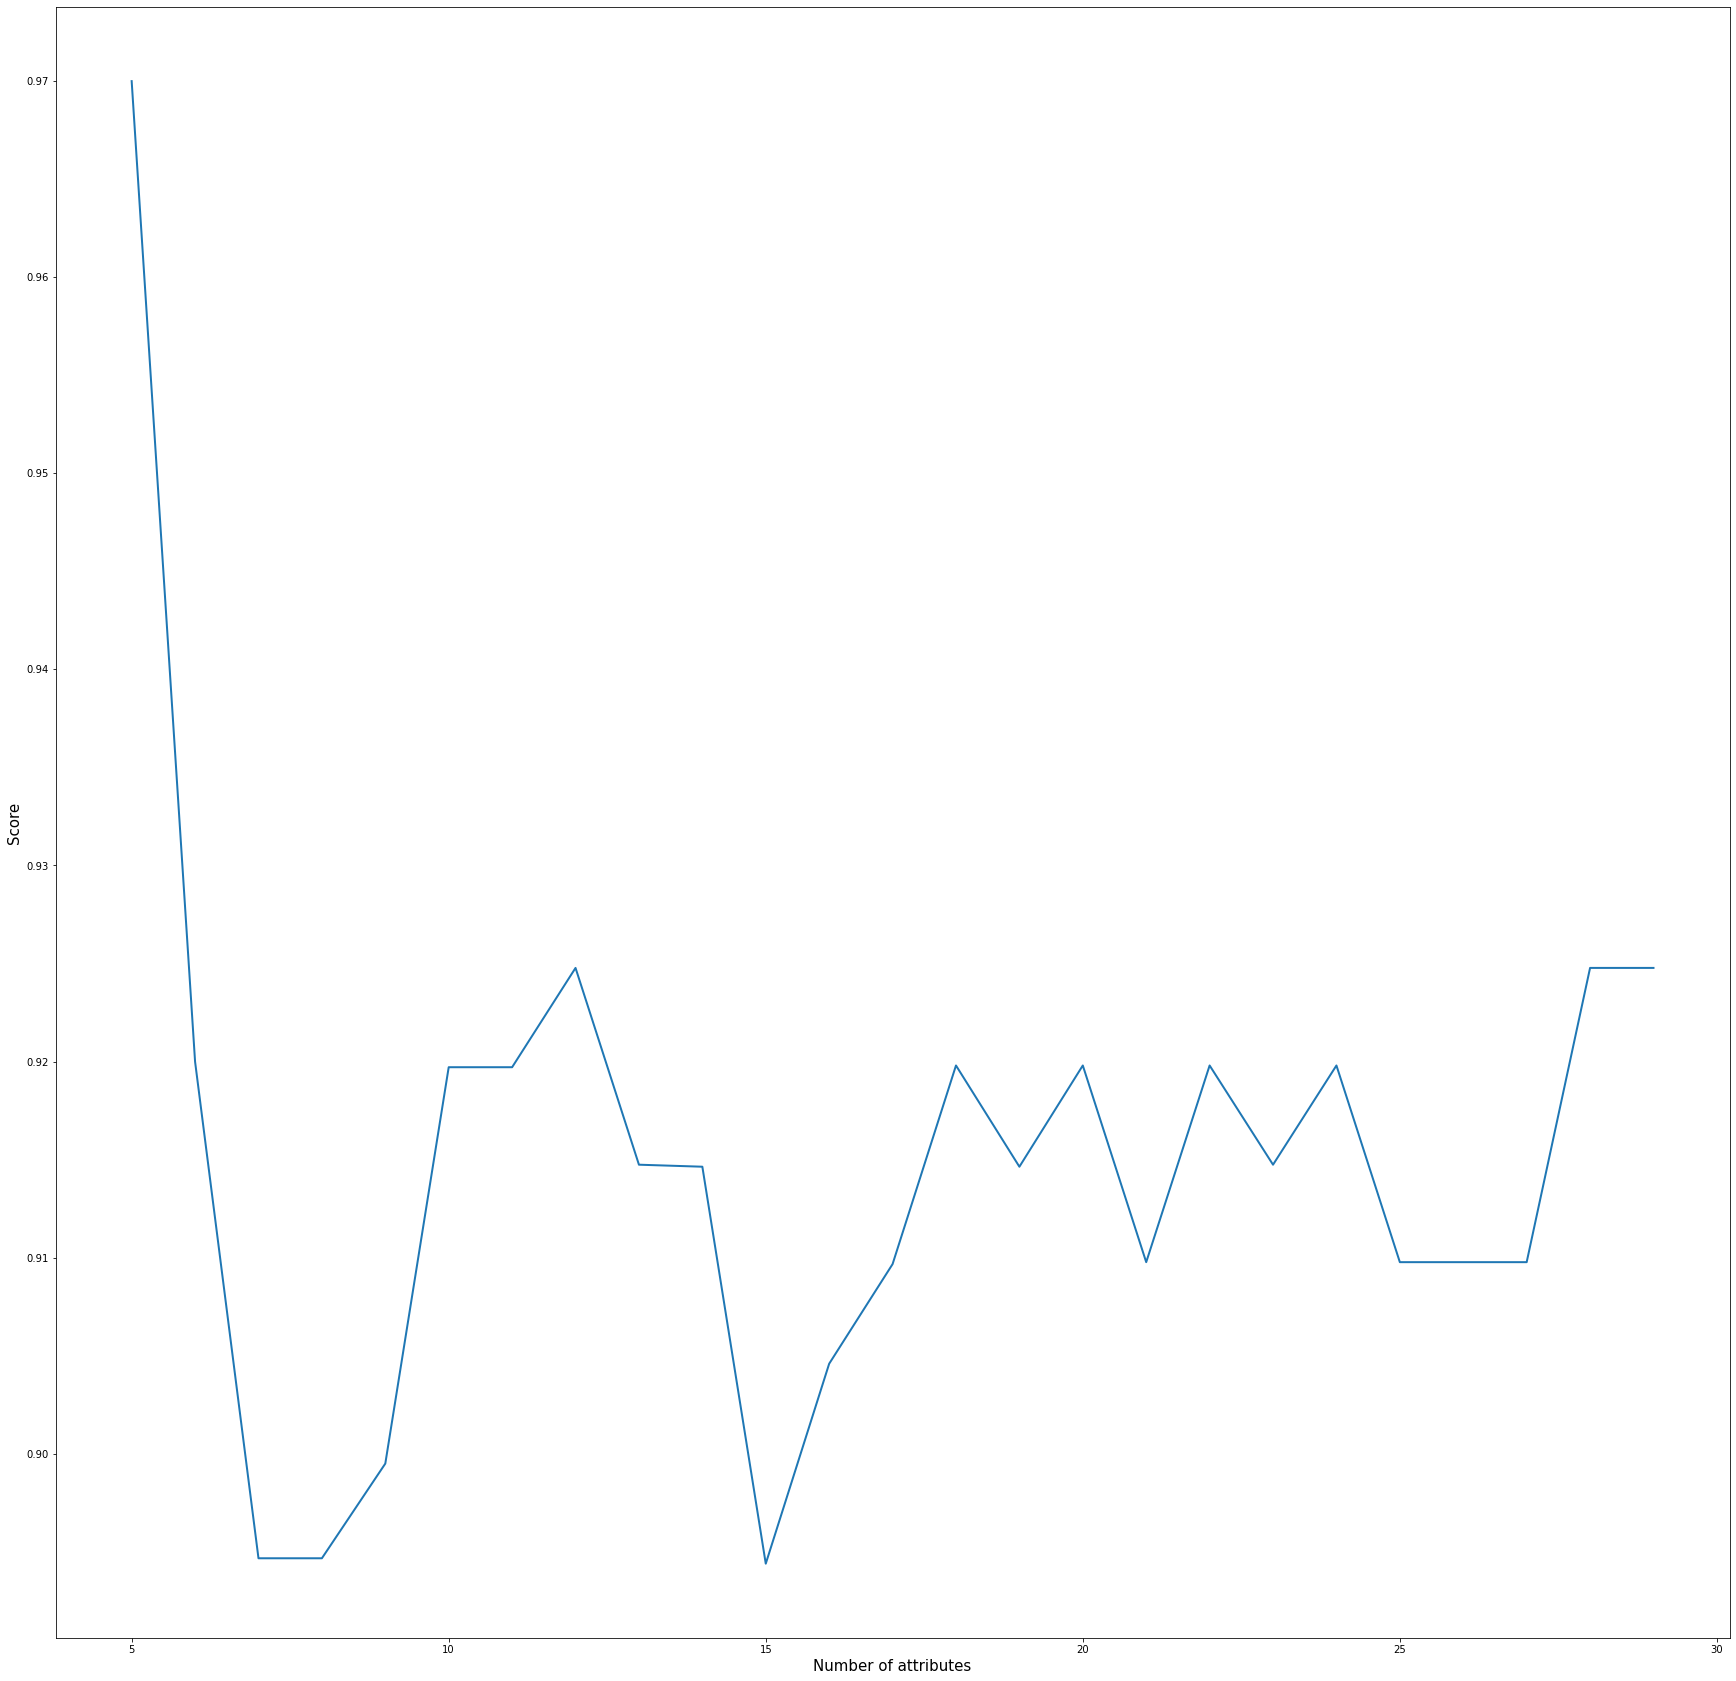

In [67]:
plt.figure(figsize=(30,30))
plt.plot(values,score, linewidth=2.0, label='fit')
plt.xlabel("Number of attributes",fontsize = 15)
plt.ylabel("Score",fontsize = 15)

Logisticc regression's R2: with  21 0.9699729756781104


/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


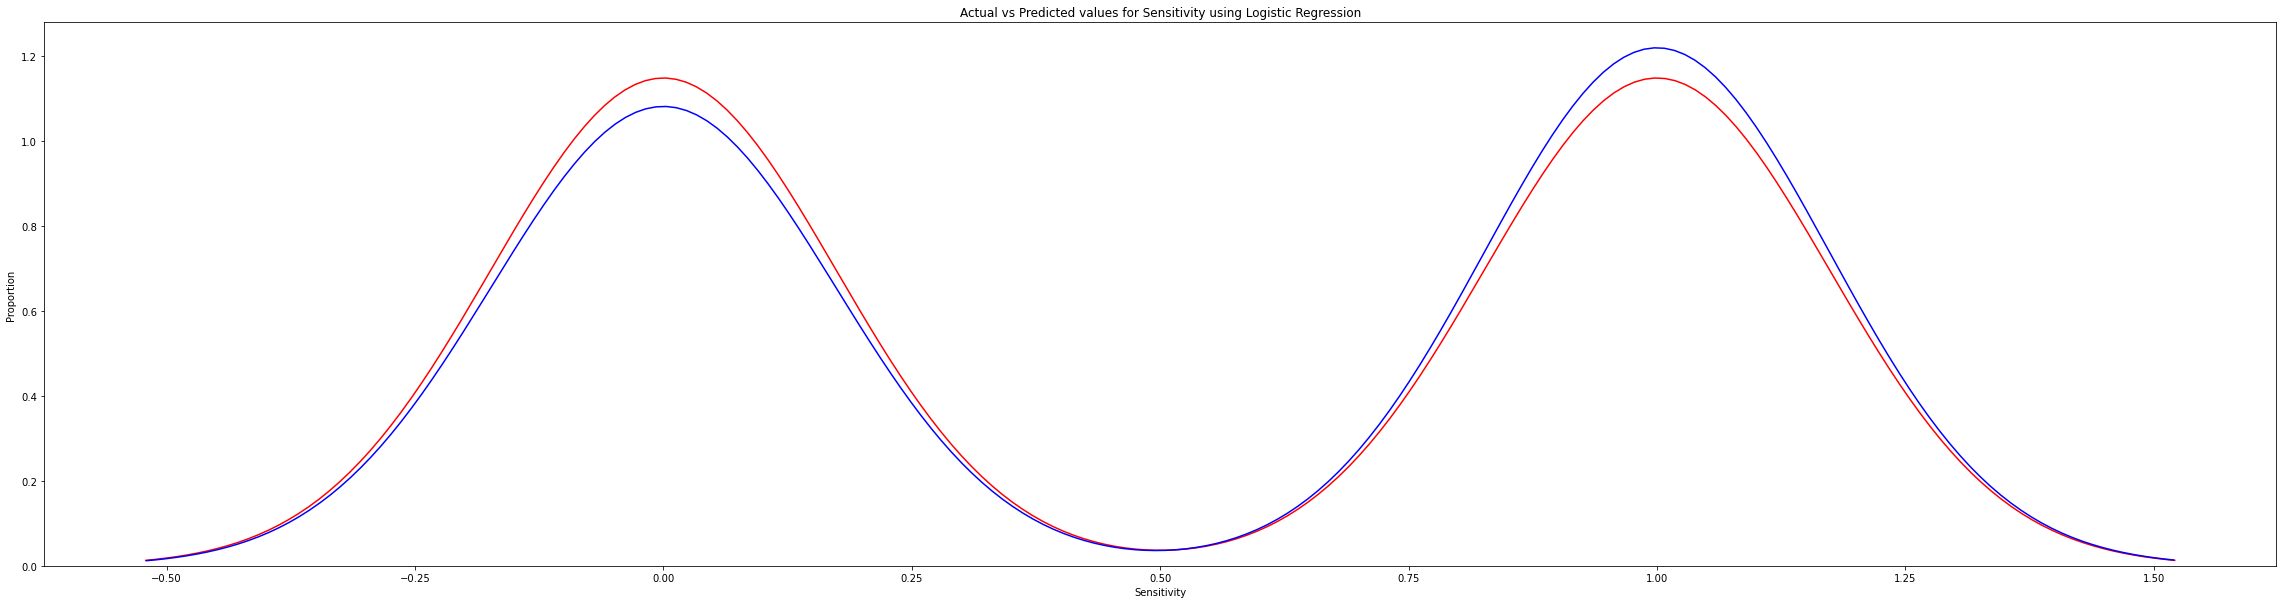

In [68]:
LR = LogisticRegression(max_iter=100,solver="saga")
cv = KFold(n_splits=5)
yhat = cross_val_predict(LR, bestFeatures, y,cv=cv)

print("Logisticc regression's R2: with ",21,metrics.f1_score(y, yhat,average='weighted'))

plt.figure(figsize=(40, 10))
sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values")

plt.title('Actual vs Predicted values for Sensitivity using Logistic Regression')
plt.xlabel('Sensitivity')
plt.ylabel('Proportion ')

plt.show()
plt.close()

### Logistic Regression with Word-Embedding

In [70]:
df_emb = pd.read_csv("./Data/dummy_df_50d.csv")

In [71]:
X = df_emb.drop("label",axis=1,inplace=False)
label_encoder = preprocessing.LabelEncoder().fit(df_emb['label'])
y = label_encoder.transform(df_emb['label'])

Logisticc regression's R2: with  21 0.9249831212022704


/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


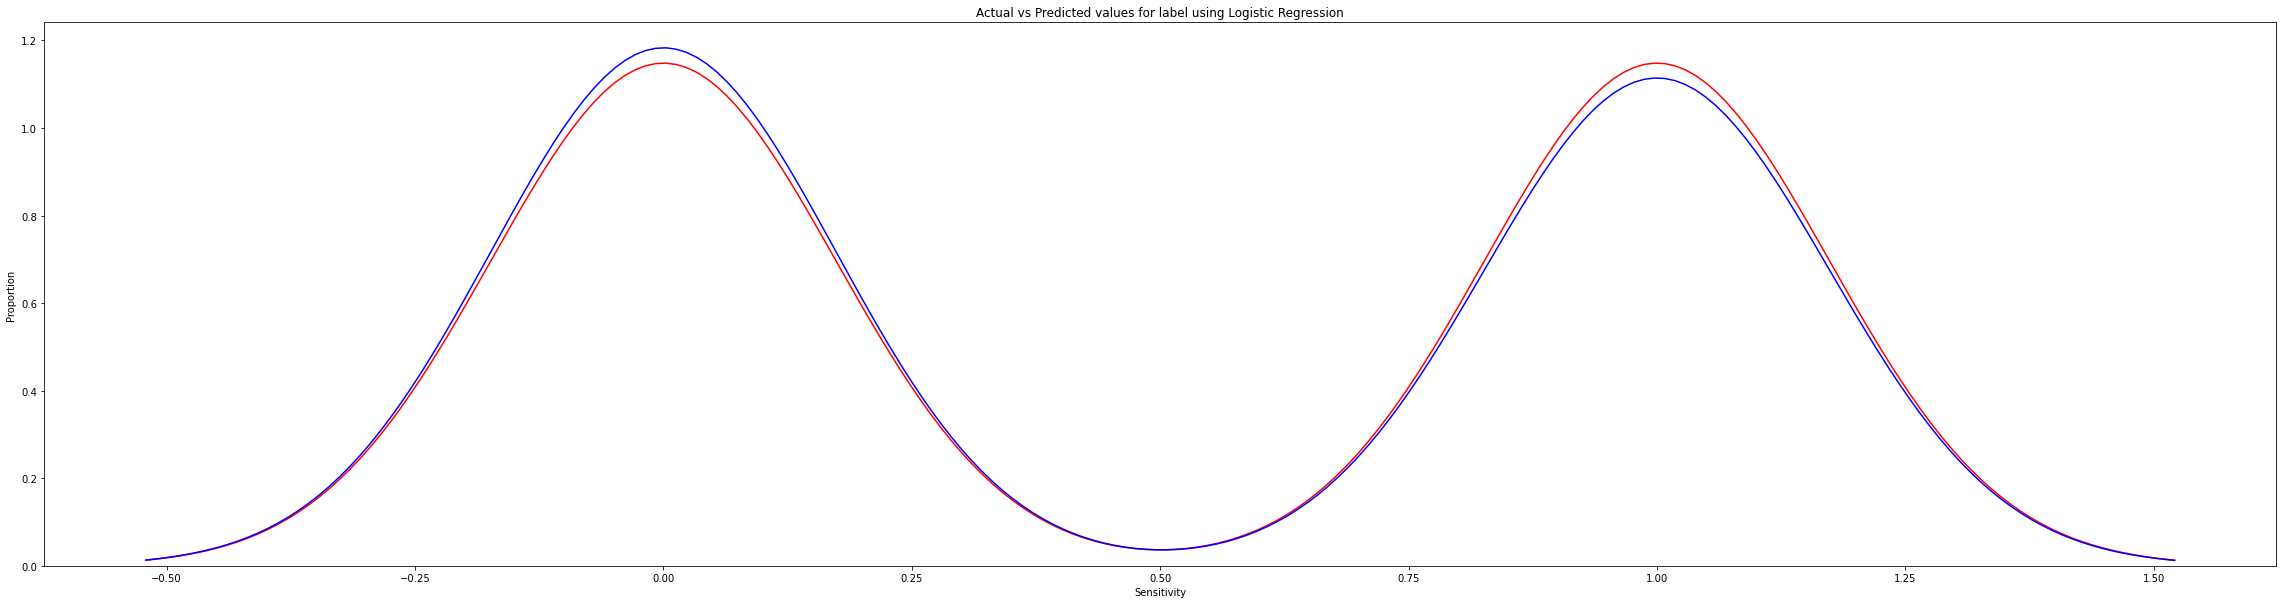

In [72]:
LR = LogisticRegression(max_iter=100,solver="saga")
cv = KFold(n_splits=5)
yhat = cross_val_predict(LR, X, y,cv=cv)

print("Logisticc regression's R2: with ",21,metrics.f1_score(y, yhat,average='weighted'))

plt.figure(figsize=(40, 10))
sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values")

plt.title('Actual vs Predicted values for label using Logistic Regression')
plt.xlabel('Sensitivity')
plt.ylabel('Proportion ')

plt.show()
plt.close()

## Neural Network <a id="52">

### Neural Network with TF-IDF

In [73]:
df_neural = pd.read_csv("./Data/dummy_df_tf.csv")
df_neural.dropna(inplace=True) 
df_neural["has_mentions"] = df["has_mentions"]
X_neural = df_neural.drop("label",axis=1,inplace=False)
label_encoder = preprocessing.LabelEncoder().fit(df_neural['label'])
y_neural = label_encoder.transform(df_neural['label'])
label_encoder = preprocessing.LabelEncoder().fit(df_neural['has_mentions'])
df_neural['has_mentions'] = label_encoder.transform(df_neural['has_mentions'])

In [74]:
best_features = SelectKBest(k=35)
fit = best_features.fit(X_neural,np.ravel(y_neural))
df_new = df_neural[X_neural.columns[fit.get_support()]]

/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [391] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/kerman/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
...     df_new, y_neural, test_size=0.33, random_state=42)

In [76]:
X_train.shape

(134, 35)

In [77]:
y_train

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [78]:
model = Sequential()
model.add(Dense(35,input_dim=35, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= "nadam",metrics=['accuracy'])

2021-11-30 00:49:25.218649: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-30 00:49:25.225288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [79]:
history = model.fit(X_train, y_train, epochs=3,batch_size=16)

2021-11-30 00:49:25.438489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3
9/9 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5093
Epoch 2/3
9/9 [==============================] - 0s 935us/step - loss: 0.0000e+00 - accuracy: 0.5361
Epoch 3/3
9/9 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5357


### Neural Network with Word-Embedding

In [80]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("./Data/dummy_preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

label_encoder = preprocessing.LabelEncoder().fit(df['label'])
y = label_encoder.transform(df['label'])
X_train, X_test, y_train, y_test = train_test_split(df['text'],y, test_size=0.30, random_state=1)

In [81]:
import tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 

sequences = tokenizer.texts_to_sequences(X_train)



word_index = tokenizer.word_index 
 

vocab_size = len(word_index)
print('Tamaño del vocabulario: ', vocab_size)

test_tokens = Tokenizer()
test_tokens.fit_on_texts(X_test)
test_sequences = test_tokens.texts_to_sequences(X_test)
test_word_index = test_tokens.word_index
test_vocab_size = len(test_word_index)
print('Tamaño del vocabulario del testeo: ', test_vocab_size )

Tamaño del vocabulario:  6692
Tamaño del vocabulario del testeo:  4119


In [82]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(sequences, padding = 'post')
X_test = pad_sequences(test_sequences, padding = 'post')

In [83]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

embedding_dim=50

model = Sequential([
  Embedding(vocab_size + 1, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          334650    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 335,483
Trainable params: 335,483
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=3
    )

Epoch 1/3
5/5 [==============================] - 1s 72ms/step - loss: 0.6924 - accuracy: 0.5152 - val_loss: 0.6920 - val_accuracy: 0.5333
Epoch 2/3
5/5 [==============================] - 0s 16ms/step - loss: 0.6920 - accuracy: 0.4926 - val_loss: 0.6921 - val_accuracy: 0.5333
Epoch 3/3
5/5 [==============================] - 0s 17ms/step - loss: 0.6892 - accuracy: 0.4991 - val_loss: 0.6925 - val_accuracy: 0.5333


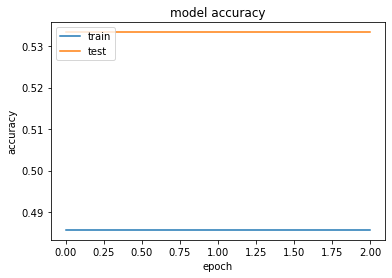

In [86]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Results <a id="6">

### Los resultados inconsistentes como en el caso anterior son debido al numero reducido de datos y la no-hiperparametrización para este notebook dummy.

Como hemos podido comprobar, los resultados que ha ofrecido el word embedding han sido mejores que el TF-IDF. Además de eso, la combinación con la red neuronal es el modelo que mejor ha funcionado. Probablemente una red neuronal de otro tipo (LSTM por ejemplo) hubiera sido más apropiado. 

| Treatments | Train Score | Test Score |
|---------------------|----------------------|---------------------|
| L.Reg + TF-IDF      | 0.751                | 0.545               |
| L.Reg + Embedding   | 0.642                | 0.535               |
| NN + TF-IDF         | 0.4842               | -                   |
| NN + Embedding      | 0.97                 | 0.7316              |

# Conclusion <a id="7">
 

En conclusión podemos decir que ha sido un proyecto muy interesante, donde se ha podido trabajar con diferentes tipos de vectorización que hemos visto en clase, combinado también con modelos previamente vistos. Del mismo modo, descubrir la posibilidad de Tokenizar mediante tensorflow ha sido muy importante, el cual no dudaré en implementar en proyectos futuros.